## Translating Wikidata queries to DBpedia with LLMs few shot learning

In [1]:
# import all the necessary libraries
import re
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from SPARQLWrapper import SPARQLWrapper, JSON
from openai import OpenAI

In [11]:
# Load the dataset from 100_complete_entries.json
with open("../../../data/100_complete_entries_wikidata.json", "r") as file:
    data = json.load(file)

# Create input dataset for the LLM
llm_inputs = []

for entry in data:
    # Extract required fields
    question = entry.get("question", "")  # Natural language question
    wikidata_query = entry.get("wikidata_query", "")  # SPARQL query for wikidata
    
    # Extract entities and relations (ER2) in dbpedia
    er2 = [
        {
            "dbpedia_id": er["dbpedia_id"],
            "wikidata_ids": er["wikidata_ids"]
        }
        for er in entry.get("mapped_entities_relations", {}).get("entities_relations", [])
        if er["dbpedia_id"]  # Only include non-empty dbpedia mappings
    ]
    
    # Skip if there are no valid Wikidata mappings
    if not er2:
        continue

    # Construct the input for the LLM
    llm_input = {
        "context": {
            "natural_language_question": question,
            "sparql_query_kg1": wikidata_query,
            "kg1_name": "Wikidata",
            "kg2_name": "DBpedia",
            "er2": er2,
            "instruction": f""""Given the information above, produce a SPARQL query for KG2. In your answer please hightlight the final, complete SPARQL query within the tags '<sparql>' and '</sparql>'. Here are 4 examples: 
            Example 1: Q: How many films did Hal Roach produce? 
            DBpedia: SELECT (COUNT(DISTINCT ?uri) AS ?c) WHERE {{ ?uri <http://dbpedia.org/ontology/producer> <http://dbpedia.org/resource/Hal_Roach> }} 
            Wikidata:SELECT (COUNT(?uri) as ?c) WHERE {{ ?uri wdt:P162 wd:Q72792 . }}; 
            Example 2: Q: List all boardgames by GMT. 
            DBpedia:SELECT ?uri WHERE {{ ?uri dbo:publisher res:GMT_Games }} 
            Wikidata: SELECT ?uri WHERE {{ ?uri wdt:P31 wd:Q131436 . }}; 
            Example 3: Q: Which organizations were founded in 1950? 
            DBpedia: SELECT DISTINCT ?uri WHERE {{ ?uri rdf:type dbo:Organisation {{ ?uri dbo:formationYear ?date }} UNION {{ ?uri dbo:foundingYear ?date }} 
            UNION {{ ?uri dbp:foundation ?date }} UNION {{ ?uri dbp:formation ?date }} FILTER regex(?date, '^1950') }} 
            Wikidata: SELECT DISTINCT ?uri WHERE {{ ?type wdt:P279* wd:Q43229 . ?uri wdt:P31 ?type . ?uri wdt:P571 ?foundedAt . FILTER CONTAINS(STR(?foundedAt), '1950') }}; 
            Example 4: Q: Which U.S. state has the highest density? 
            DBpedia: SELECT ?uri WHERE {{ ?uri dbp:densityrank ?density }} ORDER BY ASC(?density) LIMIT 1 
            Wikidata:SELECT DISTINCT ?uri WHERE {{ ?uri wdt:P31 wd:Q35657 ; wdt:P2046 ?area ; wdt:P1082 ?population . BIND((?population/?area) AS ?density) . }} ORDER BY DESC(?density) LIMIT 1"""
        }
    }
    llm_inputs.append(llm_input)

# Save the processed dataset to a new JSON file
with open("llm_input_dataset_wikidata_fewshot.json", "w") as file:
    json.dump(llm_inputs, file, indent=4)

print(f"Processed dataset saved to 'llm_input_dataset_wikidata_fewshot.json'.")

Processed dataset saved to 'llm_input_dataset_wikidata_fewshot.json'.


## Test for llama-3.1-8b-instruct
Using meta-llama-3.1-8b-instruct for the first test of translating the queries from DBpedia to Wikidata. The connection works and the model is able to translate the queries. The output is quite large, because the model also explains what as been done. Should the prompt be changed to get a more concise output, only the complete query?

**meta-llama-3.1-8b-instruct is the smallest available model at Academic Cloud https://chat-ai.academiccloud.de/chat, with 8billion parameters**

In [12]:
# Set up the LLM API connection
api_key = '0e18102475c8460f5469f8c98b0a9390'
base_url = "https://chat-ai.academiccloud.de/v1"
model = "meta-llama-3.1-8b-instruct"  # Replace with the appropriate model

# Start OpenAI client
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

# Load the input dataset
with open("llm_input_dataset_wikidata_fewshot.json", "r") as file:
    llm_input_data = json.load(file)

# Initialize the list to store the responses
translated_dataset = []

# Query the LLM for each entry in the dataset
for entry in llm_input_data:
    context = entry["context"]
    
    # Create the prompt for the LLM
    prompt = (
        f"Context:\n"
        f"Natural Language Question: {context['natural_language_question']}\n"
        f"SPARQL Query for KG1 ({context['kg1_name']}):\n"
        f"{context['sparql_query_kg1']}\n"
        f"Knowledge Graph 1 Name: {context['kg1_name']}\n"
        f"Knowledge Graph 2 Name: {context['kg2_name']}\n"
        f"Entity and Relation Mapping (ER2):\n{json.dumps(context['er2'], indent=2)}\n"
        f"Instruction: {context['instruction']}"
    )
    
    try:
        # Query the LLM
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            model=model
        )
        
        # Extract the generated SPARQL query from the response
        response_text = response.choices[0].message.content
        
        # Append the response to the translated dataset
        translated_entry = {
            "context": context,
            "sparql_query_kg2": response_text  # Add the translated SPARQL query
        }
        translated_dataset.append(translated_entry)
    
    except Exception as e:
        print(f"Error querying LLM for question ID {context.get('natural_language_question', 'unknown')}: {e}")
        continue

# Save the translated dataset to a new JSON file
with open("translated_llm_output_meta-llama-3.1-8b_fewshot_wikidata_dbpedia.json", "w") as file:
    json.dump(translated_dataset, file, indent=4)

print("Translated SPARQL queries for all questions saved to 'translated_llm_output_meta-llama-3.1-8b_fewshot_wikidata_dbpedia.json'.")


Translated SPARQL queries for all questions saved to 'translated_llm_output_meta-llama-3.1-8b_fewshot_wikidata_dbpedia.json'.


## Testing Mistral-Large-instruct with 100 queries
The model includes 123billion parameters and is the largest available model at Academic Cloud https://chat-ai.academiccloud.de

In [13]:
# Set up the LLM API connection
api_key = '0e18102475c8460f5469f8c98b0a9390'
base_url = "https://chat-ai.academiccloud.de/v1"
model = "mistral-large-instruct"

# Start OpenAI client
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

# Load the input dataset
with open("llm_input_dataset_wikidata_fewshot.json", "r") as file:
    llm_input_data = json.load(file)

# Initialize the list to store the responses
translated_dataset = []

# Query the LLM for each entry in the dataset
for entry in llm_input_data:
    context = entry["context"]
    
    # Create the prompt for the LLM
    prompt = (
        f"Context:\n"
        f"Natural Language Question: {context['natural_language_question']}\n"
        f"SPARQL Query for KG1 ({context['kg1_name']}):\n"
        f"{context['sparql_query_kg1']}\n"
        f"Knowledge Graph 1 Name: {context['kg1_name']}\n"
        f"Knowledge Graph 2 Name: {context['kg2_name']}\n"
        f"Entity and Relation Mapping (ER2):\n{json.dumps(context['er2'], indent=2)}\n"
        f"Instruction: {context['instruction']}"
    )
    
    try:
        # Query the LLM
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            model=model
        )
        
        # Extract the generated SPARQL query from the response
        response_text = response.choices[0].message.content
        
        # Append the response to the translated dataset
        translated_entry = {
            "context": context,
            "sparql_query_kg2": response_text  # Add the translated SPARQL query
        }
        translated_dataset.append(translated_entry)
    
    except Exception as e:
        print(f"Error querying LLM for question ID {context.get('natural_language_question', 'unknown')}: {e}")
        continue

# Save the translated dataset to a new JSON file
with open("translated_llm_output_mistral_fewshot_wikidata_dbpedia.json", "w") as file:
    json.dump(translated_dataset, file, indent=4)

print("Translated SPARQL queries for all questions saved to 'translated_llm_output_mistral_fewshot_wikidata_dbpedia.json'.")


Translated SPARQL queries for all questions saved to 'translated_llm_output_mistral_fewshot_wikidata_dbpedia.json'.


## Analysis of the results
For now it can be seen that the extraction process for the larger model (mistral-large-instruct) is working better than for the smaller model (meta-llama-3.1-8b-instruct). The output of the smaller model is not that structured making it harder to extract the queries. On the first sight it also seems that the queries from the larger model are working better.


Extracting the SPARQL queries from LLM output for **mistral-large-instruct**.

In [14]:
# Load the input JSON file
file_path = "translated_llm_output_mistral_fewshot_wikidata_dbpedia.json"
with open(file_path, "r") as file:
    data = json.load(file)

# Function to extract and clean SPARQL queries
def extract_sparql_query(entry):
    raw_query = entry.get("sparql_query_kg2", "").strip()
    if not raw_query:
        return None

    # Remove comments (anything after #)
    cleaned_query = re.sub(r"#.*", "", raw_query)

    # Extract content between known SPARQL markers or detect raw queries
    match = re.search(
        r"<sparql>\s*(.*?)\s*</sparql>|"  # Matches <sparql> ... </sparql>
        r"```sparql\s*(.*?)\s*```|"  # Matches ```sparql ... ```
        r"(PREFIX\s+.*?WHERE\s*\{.*?\})|"  # Matches PREFIX-based queries
        r"(SELECT\s+.*?\{.*?\})",  # Matches standard SELECT-based queries
        cleaned_query,
        re.DOTALL | re.IGNORECASE
    )

    if match:
        # Extract the first non-None group
        query = next(group for group in match.groups() if group is not None)

        # Clean query by removing excessive whitespace
        query = re.sub(r"\s+", " ", query).strip()

        return query
    return None

# Initialize counts and results tracking
queries_with_context = []
failed_queries = []
total_entries = len(data)
extracted_count = 0

# Extract SPARQL queries
for entry in data:
    natural_language_question = entry.get("context", {}).get("natural_language_question", "Unknown question")
    sparql_query = extract_sparql_query(entry)

    if sparql_query:
        queries_with_context.append({
            "natural_language_question": natural_language_question,
            "sparql_query_kg2": sparql_query
        })
        extracted_count += 1
    else:
        failed_queries.append({
            "natural_language_question": natural_language_question,
            "sparql_query_raw": entry.get("sparql_query_kg2", "")
        })

# Save the successfully extracted queries to a new JSON file
output_file = "translated_llm_output_mistral_fewshot_extracted_wikidata_dbpedia.json"
failed_output_file = "failed_sparql_queries_mistral_fewshot.json"

with open(output_file, "w") as file:
    json.dump(queries_with_context, file, indent=4)

# Save the failed queries for debugging
with open(failed_output_file, "w") as file:
    json.dump(failed_queries, file, indent=4)

# Print statistics
failed_count = len(failed_queries)
success_rate = (extracted_count / total_entries * 100) if total_entries > 0 else 0

print(f"Cleaned and extracted data has been saved to {output_file}.")
print(f"Failed extractions saved to {failed_output_file}.")
print(f"Total entries processed: {total_entries}")
print(f"Successfully extracted queries: {extracted_count}")
print(f"Failed queries: {failed_count}")
print(f"Extraction success rate: {success_rate:.2f}%")

Cleaned and extracted data has been saved to translated_llm_output_mistral_fewshot_extracted_wikidata_dbpedia.json.
Failed extractions saved to failed_sparql_queries_mistral_fewshot.json.
Total entries processed: 100
Successfully extracted queries: 100
Failed queries: 0
Extraction success rate: 100.00%


Extracting the SPARQL queries from LLM output from **lama-3.1-8b-instruct**.

In [15]:
input_file_path = 'translated_llm_output_meta-llama-3.1-8b_fewshot_wikidata_dbpedia.json'
output_file_path = 'translated_llm_output_meta-llama-3.1-8b_fewshot_extracted_wikidata_dbpedia.json'

# Load the JSON file
with open(input_file_path, 'r') as file:
    data = json.load(file)

# Function to extract and clean SPARQL queries
def extract_and_clean_sparql_query(sparql_raw):
    try:
        # Look for SPARQL queries in various formats
        sparql_match = re.search(r"<sparql>(.*?)</sparql>", sparql_raw, re.DOTALL)

        if not sparql_match:
            # Check for triple-backtick SPARQL code blocks
            sparql_match = re.search(r"```sparql\s*(.*?)\s*```", sparql_raw, re.DOTALL)
        
        if not sparql_match:
            # Check for PREFIX-based queries, allowing additional text before or after
            sparql_match = re.search(r"(PREFIX.*?WHERE\s*\{.*?\})", sparql_raw, re.DOTALL)
        
        if not sparql_match:
            # Try capturing any SELECT query structure in case it's wrapped in text
            sparql_match = re.search(r"(SELECT\s+\?.*?\{.*?\})", sparql_raw, re.DOTALL)

        if sparql_match:
            # Extract the matched query
            query = sparql_match.group(1) or sparql_match.group(0)

            # Clean query by removing comments and excess whitespace
            query = re.sub(r"#.*", "", query)  # Remove comments
            query = re.sub(r"\s+", " ", query).strip()  # Remove excessive whitespace and newlines

            # Remove possible enclosing tags or markers
            query = re.sub(r"```sparql|```|<sparql>|</sparql>", "", query).strip()

            return query
    except Exception as e:
        print(f"Error cleaning SPARQL query: {e}")
    
    return None

# Initialize results tracking
result = []
failed_queries = []
total_entries = len(data)
extracted_count = 0

# Process all entries and keep natural language question with the query
for entry in data:
    context = entry.get('context', {})
    natural_language_question = context.get('natural_language_question', None)
    sparql_query_raw = entry.get('sparql_query_kg2', '')

    # Extract and clean the SPARQL query
    sparql_query = extract_and_clean_sparql_query(sparql_query_raw)

    if natural_language_question and sparql_query:
        result.append({
            "natural_language_question": natural_language_question,
            "sparql_query": sparql_query
        })
        extracted_count += 1
    else:
        failed_queries.append({
            "natural_language_question": natural_language_question,
            "sparql_query_raw": sparql_query_raw
        })

# Save the successfully extracted queries to a new JSON file
with open(output_file_path, 'w') as output_file:
    json.dump(result, output_file, indent=4)

# Print statistics
failed_count = total_entries - extracted_count
success_rate = (extracted_count / total_entries) * 100 if total_entries > 0 else 0

print(f"Cleaned and extracted data has been saved to {output_file_path}.")
print(f"Total entries processed: {total_entries}")
print(f"Successfully extracted queries: {extracted_count}")
print(f"Failed queries: {failed_count}")
print(f"Extraction success rate: {success_rate:.2f}%")

Cleaned and extracted data has been saved to translated_llm_output_meta-llama-3.1-8b_fewshot_extracted_wikidata_dbpedia.json.
Total entries processed: 100
Successfully extracted queries: 100
Failed queries: 0
Extraction success rate: 100.00%


## Run the extracted SPARQL queries on DBpedia 
Results for **mistral-large-instruct**.

Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'{\n    "exception": "Invalid SPARQL query: Prefix rdf was not registered using a PREFIX declaration",\n    "metadata": {\n        "line": 1,\n        "positionInLine": 163,\n        "query": "PREFIX dbo: <http://dbpedia.org/ontology/> PREFIX dbp: <http://dbpedia.org/property/> PREFIX dbr: <http://dbpedia.org/resource/> SELECT DISTINCT ?uri WHERE { ?uri rdf:type dbo:Musical ; dbo:musicBy dbr:Elton_John . }",\n        "startIndex": 163,\n        "stopIndex": 170\n    },\n    "query": "PREFIX dbo: <http://dbpedia.org/ontology/> PREFIX dbp: <http://dbpedia.org/property/> PREFIX dbr: <http://dbpedia.org/resource/> SELECT DISTINCT ?uri WHERE { ?uri rdf:type dbo:Musical ; dbo:musicBy dbr:Elton_John . }",\n    "resultsize": 0,\n    "status": "ERROR",\n    "time": {\n        "computeResult": 1,\n        "total": 1\n    }\n}'
Query failed: QueryBadFormed: A bad requ

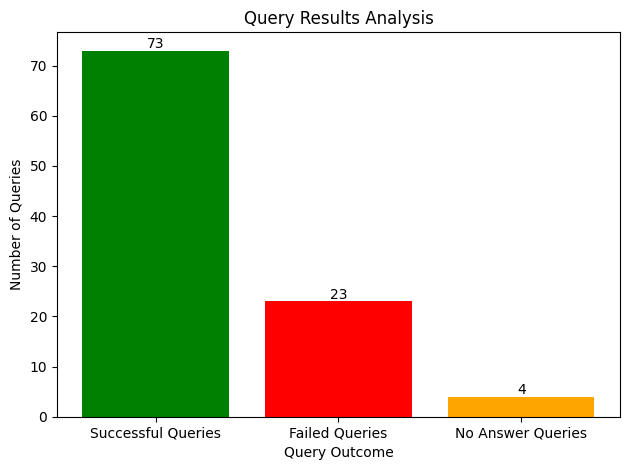

In [16]:
# File paths
input_file_path = "translated_llm_output_mistral_fewshot_extracted_wikidata_dbpedia.json"
output_file_path = "results_mistral_fewshot_wikidata_dbpedia.json"

# Wikidata local endpoint
DBpedia_ENDPOINT = "http://localhost:7012"

# Define prefixes for the queries
PREFIXES = """
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX res: <http://dbpedia.org/resource/>
PREFIX yago: <http://dbpedia.org/class/yago/>
PREFIX onto: <http://dbpedia.org/ontology/>
PREFIX dbp: <http://dbpedia.org/property/>
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX dbc: <http://dbpedia.org/resource/Category:>
PREFIX dct: <http://purl.org/dc/terms/>
"""

# Function to check and prepend prefixes if not present
def ensure_prefixes(query):
    if not query.strip().startswith("PREFIX"):
        return PREFIXES + query
    return query

# Function to query the SPARQL endpoint
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)
    
    try:
        return sparql.query().convert()  # Return results
    except Exception as e:
        print(f"Query failed: {e}")
        return None

# Extract the answers from the SPARQL query results
def extract_answer(results):
    if not results:
        return ["Query failed"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Append the value directly
    return answers if answers else ["No answer"]

# Load the input dataset
with open(input_file_path, "r") as file:
    data = json.load(file)

# Initialize results list
query_results = []

# Process each query in the dataset
for entry in data:
    question = entry.get("natural_language_question", "")
    sparql_query = entry.get("sparql_query_kg2", "")
    
    if not sparql_query:
        print(f"No SPARQL query found for question: {question}")
        continue

    # Ensure prefixes are included in the query
    sparql_query_with_prefixes = ensure_prefixes(sparql_query)

    # Execute the query on the DBpedia endpoint
    results = query_sparql(DBpedia_ENDPOINT, sparql_query_with_prefixes)
    extracted_answers = extract_answer(results)
    
    # Append the query results
    query_results.append({
        "natural_language_question": question,
        "sparql_query": sparql_query_with_prefixes,
        "answers": extracted_answers
    })

# Save the results to a JSON file
with open(output_file_path, "w") as output_file:
    json.dump(query_results, output_file, indent=4)

print(f"Query results saved to {output_file_path}.")

# Calculate accuracy and categorize results
total_queries = len(data)
successful_queries = sum(1 for result in query_results if "No answer" not in result["answers"] and "Query failed" not in result["answers"])
failed_queries = sum(1 for result in query_results if "Query failed" in result["answers"])
no_answer_queries = sum(1 for result in query_results if "No answer" in result["answers"])
accuracy = (successful_queries / total_queries) * 100 if total_queries > 0 else 0

print(f"Total Queries: {total_queries}")
print(f"Successful Queries: {successful_queries}")
print(f"Failed Queries: {failed_queries}")
print(f"No Answer Queries: {no_answer_queries}")
print(f"Accuracy: {accuracy:.2f}%")

# Visualize results with a bar chart
categories = ['Successful Queries', 'Failed Queries', 'No Answer Queries']
counts = [successful_queries, failed_queries, no_answer_queries]
colors = ['green', 'red', 'orange']

plt.bar(categories, counts, color=colors)
plt.title('Query Results Analysis')
plt.ylabel('Number of Queries')
plt.xlabel('Query Outcome')
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center')
plt.tight_layout()
plt.show()

Results for **lama-3.1-8b-instruct**.

Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'{\n    "exception": "Invalid SPARQL query: Token \\"\' and \'\\": no viable alternative at input \'PREFIXdbo:<http://dbpedia.org/ontology/>PREFIXres:<http://dbpedia.org/resource/>PREFIXyago:<http://dbpedia.org/class/yago/>PREFIXonto:<http://dbpedia.org/ontology/>PREFIXdbp:<http://dbpedia.org/property/>PREFIXdbr:<http://dbpedia.org/resource/>PREFIXskos:<http://www.w3.org/2004/02/skos/core#>PREFIXdbc:<http://dbpedia.org/resource/Category:>PREFIXdct:<http://purl.org/dc/terms/>\' and \'\'",\n    "metadata": {\n        "line": 11,\n        "positionInLine": 0,\n        "query": "\\nPREFIX dbo: <http://dbpedia.org/ontology/>\\nPREFIX res: <http://dbpedia.org/resource/>\\nPREFIX yago: <http://dbpedia.org/class/yago/>\\nPREFIX onto: <http://dbpedia.org/ontology/>\\nPREFIX dbp: <http://dbpedia.org/property/>\\nPREFIX dbr: <http://dbpedia.org/resource/>\\nPREFIX sko

c:\Users\malte\AppData\Local\Programs\Python\Python313\Lib\site-packages\SPARQLWrapper\Wrapper.py:623: RuntimeWarning: not detected query type for query ''PREFIX dbo: <http://dbpedia.org/ontology/> PREFIX dbp: <http://dbpedia.org/properties/> PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns SELECT DISTINCT ?uri WHERE { ?uri dbo:Bridges dbp:crosses <http://dbpedia.org/resource/Seine> . }''
  warnings.warn(


Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'{\n    "exception": "Invalid SPARQL query: Token \\"\' and \'\\": no viable alternative at input \'PREFIXdbo:<http://dbpedia.org/ontology/>PREFIXres:<http://dbpedia.org/resource/>PREFIXyago:<http://dbpedia.org/class/yago/>PREFIXonto:<http://dbpedia.org/ontology/>PREFIXdbp:<http://dbpedia.org/property/>PREFIXdbr:<http://dbpedia.org/resource/>PREFIXskos:<http://www.w3.org/2004/02/skos/core#>PREFIXdbc:<http://dbpedia.org/resource/Category:>PREFIXdct:<http://purl.org/dc/terms/>\' and \'\'",\n    "metadata": {\n        "line": 11,\n        "positionInLine": 0,\n        "query": "\\nPREFIX dbo: <http://dbpedia.org/ontology/>\\nPREFIX res: <http://dbpedia.org/resource/>\\nPREFIX yago: <http://dbpedia.org/class/yago/>\\nPREFIX onto: <http://dbpedia.org/ontology/>\\nPREFIX dbp: <http://dbpedia.org/property/>\\nPREFIX dbr: <http://dbpedia.org/resource/>\\nPREFIX sko

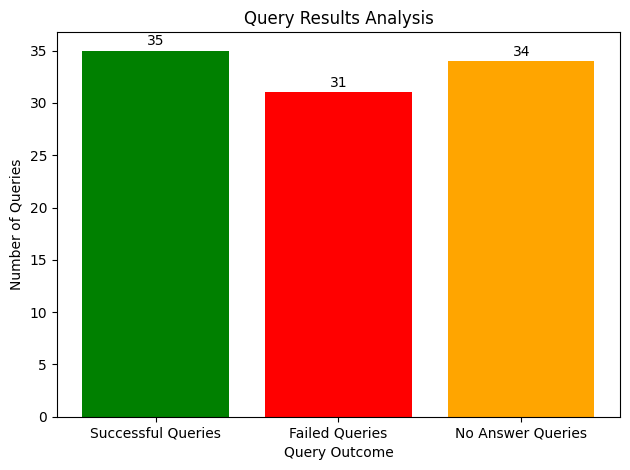

In [17]:
# File paths
input_file_path = "translated_llm_output_meta-llama-3.1-8b_fewshot_extracted_wikidata_dbpedia.json"
output_file_path = "results_llama_fewshot_wikidata_dbpedia.json"

# Wikidata local endpoint
DBpedia_ENDPOINT = "http://localhost:7012"

# Define prefixes for the queries
PREFIXES = """
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX res: <http://dbpedia.org/resource/>
PREFIX yago: <http://dbpedia.org/class/yago/>
PREFIX onto: <http://dbpedia.org/ontology/>
PREFIX dbp: <http://dbpedia.org/property/>
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX dbc: <http://dbpedia.org/resource/Category:>
PREFIX dct: <http://purl.org/dc/terms/>
"""

# Function to check and prepend prefixes if not present
def ensure_prefixes(query):
    if not query.strip().startswith("PREFIX"):
        return PREFIXES + query
    return query

# Function to query the SPARQL endpoint
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)
    
    try:
        return sparql.query().convert()  # Return results
    except Exception as e:
        print(f"Query failed: {e}")
        return None

# Extract the answers from the SPARQL query results
def extract_answer(results):
    if not results:
        return ["Query failed"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Append the value directly
    return answers if answers else ["No answer"]

# Load the input dataset
with open(input_file_path, "r") as file:
    data = json.load(file)

# Initialize results list
query_results = []

# Process each query in the dataset
for entry in data:
    question = entry.get("natural_language_question", "")
    sparql_query = entry.get("sparql_query", "")
    
    if not sparql_query:
        print(f"No SPARQL query found for question: {question}")
        continue

    # Ensure prefixes are included in the query
    sparql_query_with_prefixes = ensure_prefixes(sparql_query)

    # Execute the query on the DBpedia endpoint
    results = query_sparql(DBpedia_ENDPOINT, sparql_query_with_prefixes)
    extracted_answers = extract_answer(results)
    
    # Append the query results
    query_results.append({
        "natural_language_question": question,
        "sparql_query": sparql_query_with_prefixes,
        "answers": extracted_answers
    })

# Save the results to a JSON file
with open(output_file_path, "w") as output_file:
    json.dump(query_results, output_file, indent=4)

print(f"Query results saved to {output_file_path}.")

# Calculate accuracy and categorize results
total_queries = len(data)
successful_queries = sum(1 for result in query_results if "No answer" not in result["answers"] and "Query failed" not in result["answers"])
failed_queries = sum(1 for result in query_results if "Query failed" in result["answers"])
no_answer_queries = sum(1 for result in query_results if "No answer" in result["answers"])
accuracy = (successful_queries / total_queries) * 100 if total_queries > 0 else 0

print(f"Total Queries: {total_queries}")
print(f"Successful Queries: {successful_queries}")
print(f"Failed Queries: {failed_queries}")
print(f"No Answer Queries: {no_answer_queries}")
print(f"Accuracy: {accuracy:.2f}%")

# Visualize results with a bar chart
categories = ['Successful Queries', 'Failed Queries', 'No Answer Queries']
counts = [successful_queries, failed_queries, no_answer_queries]
colors = ['green', 'red', 'orange']

plt.bar(categories, counts, color=colors)
plt.title('Query Results Analysis')
plt.ylabel('Number of Queries')
plt.xlabel('Query Outcome')
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center')
plt.tight_layout()
plt.show()

## Comparison of DBpedia output with gold label output
In the following the final output of querying DBpedia is compared to the original output of querying QALD9-Plus dataset.

### Comparison lama-3.1-8b-instruct_template with original output

Comparison completed. Results saved to 'comparison_results_llama_fewshot_wikidata_dbpedia.xlsx'.
Total Queries: 100
Correct Queries: 32
Incorrect Queries (executed but wrong answer): 3
Query Failed to execute: 31
No Answer Queries (executed but empty answer): 34
Accuracy: 32.00%
Execution Success Rate (ESR): 35.00%


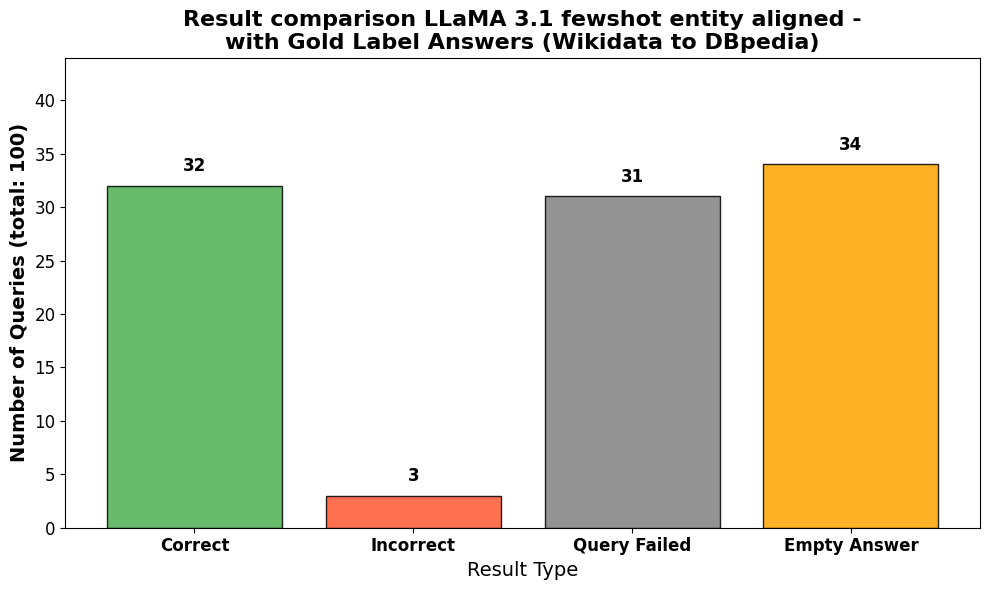

In [18]:
# Define file paths
solution_file_path = "../../../data/100_complete_entries_solution.json"
lama_output_file_path = "results_llama_fewshot_wikidata_dbpedia.json"

# Load datasets
with open(solution_file_path, 'r') as f:
    solution_data = json.load(f)

with open(lama_output_file_path, 'r') as f:
    lama_output_data = json.load(f)

# Initialize comparison results
comparison_results = []

# Create a mapping of questions to their expected results in the solution dataset
solution_mapping = {entry['question']: entry['dbpedia_results'] for entry in solution_data}

# Compare answers
total_questions = len(lama_output_data)
correct_count = 0
incorrect_count = 0
query_failed_count = 0
no_answer_count = 0
successful_executions = 0  # To calculate Execution Success Rate (ESR)

for lama_entry in lama_output_data:
    question = lama_entry.get("natural_language_question")
    lama_answers = lama_entry.get("answers", [])

    # Count query failures and no answers
    if "Query failed" in lama_answers:
        query_failed_count += 1
        continue
    if "No answer" in lama_answers:
        no_answer_count += 1
        continue

    expected_answers = solution_mapping.get(question)
    if expected_answers:
        # Check if all expected answers are in the LLM output and vice versa (ignoring order)
        is_correct = set(expected_answers) == set(lama_answers)
        comparison_results.append({
            "question": question,
            "expected_answers": expected_answers,
            "lama_answers": lama_answers,
            "is_correct": is_correct
        })
        if is_correct:
            correct_count += 1
        else:
            incorrect_count += 1

    # Count successful query executions (any result other than "Query failed")
    if lama_answers and "Query failed" not in lama_answers:
        successful_executions += 1

# Save the results to an Excel file for review
output_excel_file = "comparison_results_llama_fewshot_wikidata_dbpedia.xlsx"
results_df = pd.DataFrame(comparison_results)
results_df.to_excel(output_excel_file, index=False)

# Calculate accuracy
accuracy = (correct_count / total_questions) * 100 if total_questions > 0 else 0

# Calculate execution success rate (ESR)
execution_success_rate = (successful_executions / total_questions) * 100 if total_questions > 0 else 0

print(f"Comparison completed. Results saved to '{output_excel_file}'.")
print(f"Total Queries: {total_questions}")
print(f"Correct Queries: {correct_count}")
print(f"Incorrect Queries (executed but wrong answer): {incorrect_count}")
print(f"Query Failed to execute: {query_failed_count}")
print(f"No Answer Queries (executed but empty answer): {no_answer_count}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Execution Success Rate (ESR): {execution_success_rate:.2f}%")

# Visualize the results
categories = ['Correct', 'Incorrect', 'Query Failed', 'Empty Answer']
counts = [correct_count, incorrect_count, query_failed_count, no_answer_count]
colors = ['#4CAF50', '#FF5733', '#808080', '#FFA500']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(categories, counts, color=colors, alpha=0.85, edgecolor='black')

# Annotate bars with their values
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Configure y-axis to show only integer values with total queries in parentheses
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_ylabel(f'Number of Queries (total: {total_questions})', fontsize=14, fontweight='bold')

# Add title and labels with improved aesthetics
plt.title('Result comparison LLaMA 3.1 fewshot entity aligned -\nwith Gold Label Answers (Wikidata to DBpedia)', fontsize=16, fontweight='bold')
plt.xlabel('Result Type', fontsize=14)

# Enhance visual appeal
plt.grid(axis='y', linestyle='', alpha=0.7)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)
plt.ylim(0, max(counts) + 10)

# Show the plot
plt.tight_layout()
plt.show()

### Comparison mistral-large-instruct with original output

Comparison completed. Results saved to 'comparison_results_mistral_fewshot_wikidata_dbpedia.xlsx'.
Total Queries: 100
Correct Queries: 64
Incorrect Queries (executed but wrong answer): 9
Query Failed to execute: 23
No Answer Queries (executed but empty answer): 4
Accuracy: 64.00%
Execution Success Rate (ESR): 73.00%


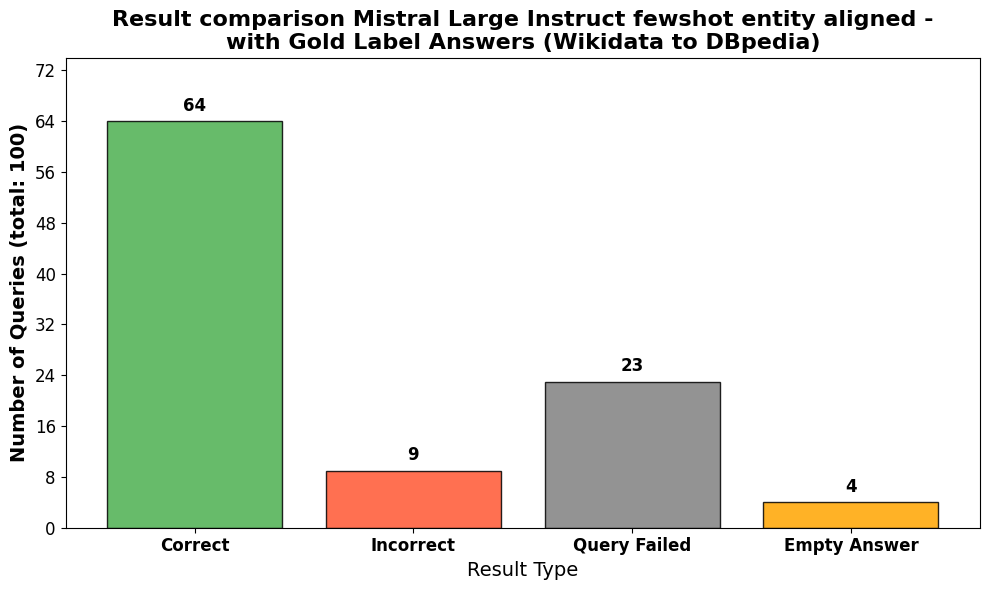

In [19]:
# Define file paths
solution_file_path = "../../../data/100_complete_entries_solution.json"
mistral_output_file_path = "results_mistral_fewshot_wikidata_dbpedia.json"

# Load datasets
with open(solution_file_path, 'r') as f:
    solution_data = json.load(f)

with open(mistral_output_file_path, 'r') as f:
    mistral_output_data = json.load(f)

# Initialize comparison results
comparison_results = []

# Create a mapping of questions to their expected results in the solution dataset
solution_mapping = {entry['question']: entry['dbpedia_results'] for entry in solution_data}

# Compare answers
total_questions = len(mistral_output_data)
correct_count = 0
incorrect_count = 0
query_failed_count = 0
no_answer_count = 0
successful_executions = 0  # To calculate Execution Success Rate (ESR)

for mistral_entry in mistral_output_data:
    question = mistral_entry.get("natural_language_question")
    mistral_answers = mistral_entry.get("answers", [])

    # Count query failures and no answers
    if "Query failed" in mistral_answers:
        query_failed_count += 1
        continue
    if "No answer" in mistral_answers:
        no_answer_count += 1
        continue

    expected_answers = solution_mapping.get(question)
    if expected_answers:
        # Check if all expected answers are in the LLM output and vice versa (ignoring order)
        is_correct = set(expected_answers) == set(mistral_answers)
        comparison_results.append({
            "question": question,
            "expected_answers": expected_answers,
            "mistral_answers": mistral_answers,
            "is_correct": is_correct
        })
        if is_correct:
            correct_count += 1
        else:
            incorrect_count += 1

    # Count successful query executions (any result other than "Query failed")
    if mistral_answers and "Query failed" not in mistral_answers:
        successful_executions += 1

# Save the results to an Excel file for review
output_excel_file = "comparison_results_mistral_fewshot_wikidata_dbpedia.xlsx"
results_df = pd.DataFrame(comparison_results)
results_df.to_excel(output_excel_file, index=False)

# Calculate accuracy
accuracy = (correct_count / total_questions) * 100 if total_questions > 0 else 0

# Calculate execution success rate (ESR)
execution_success_rate = (successful_executions / total_questions) * 100 if total_questions > 0 else 0

print(f"Comparison completed. Results saved to '{output_excel_file}'.")
print(f"Total Queries: {total_questions}")
print(f"Correct Queries: {correct_count}")
print(f"Incorrect Queries (executed but wrong answer): {incorrect_count}")
print(f"Query Failed to execute: {query_failed_count}")
print(f"No Answer Queries (executed but empty answer): {no_answer_count}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Execution Success Rate (ESR): {execution_success_rate:.2f}%")

# Visualize the results
categories = ['Correct', 'Incorrect', 'Query Failed', 'Empty Answer']
counts = [correct_count, incorrect_count, query_failed_count, no_answer_count]
colors = ['#4CAF50', '#FF5733', '#808080', '#FFA500']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(categories, counts, color=colors, alpha=0.85, edgecolor='black')

# Annotate bars with their values
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Configure y-axis to show only integer values with total queries in parentheses
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_ylabel(f'Number of Queries (total: {total_questions})', fontsize=14, fontweight='bold')

# Add title and labels with improved aesthetics
plt.title('Result comparison Mistral Large Instruct fewshot entity aligned -\nwith Gold Label Answers (Wikidata to DBpedia)', fontsize=16, fontweight='bold')
plt.xlabel('Result Type', fontsize=14)

plt.grid(axis='y', linestyle='', alpha=0.7)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)
plt.ylim(0, max(counts) + 10)

# Show the plot
plt.tight_layout()
plt.show()